<a href="https://colab.research.google.com/github/tomashphill/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/MOMA_Model/BW2_Initial_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# read in artists and artworks from the MOMA dataset
artists = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artists.csv')
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [ ]:
# I will use the subset of drawings and paintings for predictions,
# when the object is classified as painting or drawing
drawings_and_paintings = (artworks['Classification'] == 'Painting') \
                       | (artworks['Classification'] == 'Drawing')

artworks = artworks[drawings_and_paintings]
artworks['Classification'].value_counts()

Drawing     13372
Painting     2362
Name: Classification, dtype: int64

In [ ]:
# merge artworks and artists on 'Artist'
# in artists.csv, DisplayName is the artist name, therefore
# to merge, I need it so both have the same column name: artist
artists = artists.rename(columns={'DisplayName':'Artist'})
artworks = pd.merge(artworks, artists, how='inner', on='Artist')

In [ ]:
artworks.head(1)

,Title,Artist,ConstituentID_x,ArtistBio_x,Nationality_x,BeginDate_x,EndDate_x,Gender_x,Date,Medium,Dimensions,CreditLine,AccessionNumber,Classification,Department,DateAcquired,Cataloged,ObjectID,URL,ThumbnailURL,Circumference (cm),Depth (cm),Diameter (cm),Height (cm),Length (cm),Weight (kg),Width (cm),Seat Height (cm),Duration (sec.),ConstituentID_y,ArtistBio_y,Nationality_y,Gender_y,BeginDate_y,EndDate_y,Wiki QID,ULAN
0,"""Society of Monkeys"" diploma",Aleksei Remizov,14185,"(Russian, 1877–1957)",(),(1877),(1957),(Male),1922,"Watercolor, ink, cut-and-pasted colored and me...","sheet (irreg.): 9 7/16 x 12 1/2"" (23.9 x 31.8 cm)",Gift of The Judith Rothschild Foundation,2.2001,Drawing,Drawings & Prints,2001-01-24,Y,9020,http://www.moma.org/collection/works/9020,http://www.moma.org/media/W1siZiIsIjI0OTM4NiJd...,NaN,NaN,NaN,23.9,NaN,NaN,31.8,NaN,NaN,14185,"Russian, 1877–1957",NaN,Male,1877,1957,NaN,NaN


In [ ]:
# display percent of null values in columns where the percent
# is greater than 10%. These are indicative of columns I will most
# definitely drop.
((artworks.isnull().sum() / artworks.shape[0] * 100)
  .loc[lambda x: x > 10]
  .apply(round)
  .apply(str)
  .apply(lambda x: x + '%')
)

ThumbnailURL           22%
Circumference (cm)    100%
Depth (cm)             90%
Diameter (cm)         100%
Length (cm)           100%
Weight (kg)           100%
Seat Height (cm)      100%
Duration (sec.)       100%
Wiki QID               31%
ULAN                   31%
dtype: object

In [ ]:
def wrangle(df):
  df = df.copy()

  # add feature labeling whether artwork has title or not
  df['Title?'] = (df['Title'] != 'Untitled')

  # drop all these! Useless! Off with them!
  toDrop = ['ConstituentID_x', 'ArtistBio_x', 'BeginDate_x', 'EndDate_x', 
            'Gender_x', 'CreditLine', 'AccessionNumber', 'Department', 
            'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 
            'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)',
            'Length (cm)', 'Weight (kg)', 'Seat Height (cm)',
            'Duration (sec.)', 'Wiki QID', 'ULAN', 'ConstituentID_y',
            'ArtistBio_y', 'BeginDate_y', 'EndDate_y', 'Nationality_x',
            'Dimensions', 'Medium']

  df = df.drop(toDrop, axis=1)

  # drop any objects without a ThumbnailURL
  df = df.dropna(subset=['ThumbnailURL'])

  toRename = {'Nationality_y': 'Nationality',
              'Gender_y': 'Gender'}

  df = df.rename(columns=toRename)

  # since I don't know regex stuff yet, this is the best I can do to extract
  # irregular entries of date in the 'Date' column.
  def keep(char):
    return (char.isdigit() or char =='-' or char == ',')

  df['Date'] = ( df['Date']
            .astype(str)

            # filter strings for only digits=, '-', and ','
            # then, replacce ',' with '-'
            .apply(lambda s: ''.join(i for i in s if keep(i)))
            .apply(lambda s: s.replace(',','-'))

            # split into list of strings where '-' occurs, if list has only 2
            # dates (indicative of dates where it is a range of years, such as
            # 1943-1945)
            .apply(lambda s: ''.join(d for d in s.split('-') if len(d) != 2))

            # if string is empty, set it to 'n/a'
            .apply(lambda s: 'n/a' if s == '' else s)

            # if length of string is NOT a factor of 4 (meaning it might
            # contain days of the month, such as May 24, 1996)
            .apply(lambda s: s[-4:] if len(s) % 4 == 0 else 'n/a')
  )
  # get rid of unavailable dates
  df = df[df['Date'] != 'n/a']

  df['Date'] = df['Date'].astype(int)

  return df

In [ ]:
artworks = wrangle(artworks)

# split thumbnailURL into its own dataframe
thumbnails = artworks['ThumbnailURL']
artworks = artworks.drop(['ThumbnailURL'], axis=1)

In [ ]:
# checking if my 'Date' wrangling worked
artworks['Date'].sort_values()

619      1865
615      1865
667      1866
625      1866
620      1868
         ... 
14817    2018
15412    2018
14565    2018
7731     2018
1900     2019
Name: Date, Length: 11527, dtype: int64

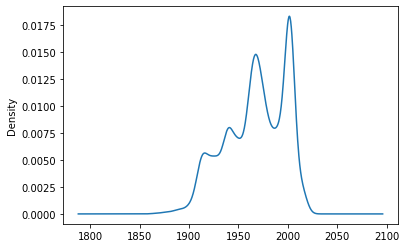

In [ ]:
# density of art artworks by year
artworks['Date'].plot(kind='density');

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import colorsys
import math

# how to load an image
response = requests.get(thumbnails.loc[8254])
img = Image.open(BytesIO(response.content))

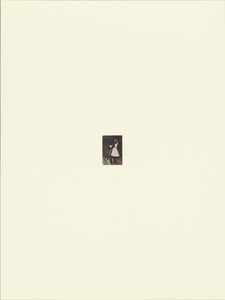

In [ ]:
# display an image
img

In [ ]:
# type of pixel, a tuple of rgb values
type(img.getpixel((0, 0)))

tuple

In [ ]:
# hue, saturation, value
# rgb in PIL is encoded in the range 0 to 255, but colorsys is encoded in
# the range 0 to 1, therefore before using rgb_to_hsv, I have to divide each
# value by 255 to map it to the correct range
colorsys.rgb_to_hsv(*[x/255.0 for x in img.getpixel((100, 200))])

(0.1439393939393938, 0.08943089430894312, 0.9647058823529412)

<font color="darkcyan">In python's encoding of hsv data, each part of the color object,
(hue, saturation, value) is encoded between 0 and 1
I want to go through an image pixel by pixel, and bin each pixel's
hsv into however amount of bins I designate. The good thing is since
the values are encoded from 0 to 1, to figure out which bin I want to 
put the value in, I can multiply that value by 1 less than however many bins I've set up, and add 1 to that number, essentially mapping the 0 to 1 range to
the 1 to length of bins range.</font>

In [ ]:
# create a new, empty dataframe where color data will reside
colorData = pd.DataFrame()

# iterate over all thumbnail images
for i, url in thumbnails.items():

  bins = {
      # hues separated into 6 bins
      '1h': 0,
      '2h': 0,
      '3h': 0,
      '4h': 0,
      '5h': 0,
      '6h': 0,
      # saturation separated into 4 bins
      '1s': 0,
      '2s': 0,
      '3s': 0,
      '4s': 0,
      # lightness separated into 4 bins
      '1v': 0,
      '2v': 0,
      '3v': 0,
      '4v': 0,
  }

  # get image data from internet
  response = requests.get(thumbnails.loc[i])
  img = Image.open(BytesIO(response.content))

  # get width/height and amount of pixels in image
  width, height = img.size
  pixels = width * height

  # some pictures might be in black and white, so "getpixel", which usually
  # returns an RGB tuple value, might only return a "lightness" int value.
  # if that's the case, then I will skip the image, adding a null dataframe
  # to colorData. This also applies to CMYK, which returns a tuple of 4
  isGray = type(img.getpixel((0, 0))) == int
  if isGray:
    isCMYK = False
  else:
    isCMYK = len(img.getpixel((0, 0))) == 4

  if (isGray or isCMYK): 
    for k, v in bins.items():
      bins[k] = np.NaN
    colorData = colorData.append(pd.DataFrame(bins, index=[i]))
    # coninute on to the next iteration from the for loop up top
    continue

  for x in range(width):
    for y in range(height):
        # PIL range:
        # Hue range is [0,179], 
        # Saturation range is [0,255],
        # and Value range is [0,255]

        # PIL uses ranges that are different from python. I have to
        # convert them to the 0 to 1 range
        rgb = [x/255.0 for x in img.getpixel((x, y))]
        h, v, s = colorsys.rgb_to_hls(*rgb)

        # increases bin count by hsv value
        bins[str(math.ceil(h*6) or 1) + 'h'] += 1
        bins[str(math.ceil(s*4) or 1) + 's'] += 1
        bins[str(math.ceil(v*4) or 1) + 'v'] += 1

  # turn bins into ratios. The sum of bins for each type will equal the
  # total amount of pixels. To get ratio we divide bin count by total pixel num
  for k, v in bins.items():
    bins[k] = round(v / pixels, 2)

  colorData = colorData.append(pd.DataFrame(bins, index=[i]))

In [ ]:
colorsys.rgb_to_hsv(1,0,.0001)

In [ ]:
# join colorData to artworks
artworks_c = artworks.join(colorData)

In [ ]:
artworks_c = artworks.join(colorData).join(thumbnails).join()

In [ ]:
artworks_c.head()

In [ ]:
artworks_c.to_csv('artworks.csv')

from google.colab import files
files.download('artworks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Split Data into Feature Matrix and Target Vector
using 'Date' as the target

In [ ]:
target = 'Date'

X = artworks_c.drop([target], axis=1)
y = artworks_c[target]

## Baseline Metric
using Mean Absolute Error metric

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, [y.mean()]*len(y))